In [ ]:
# 나눔고딕 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [3]:
import ssl
import json
from urllib.parse import quote
from urllib.request import Request, urlopen
from urllib import request
import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [4]:
s_key='BJ0BlwJg8I0JN02FYdDy3D6Own7X3vtc7G7i39Mp'

def decode_json(url):
    total_data = []
    response = request.urlopen(url)
    json_response = response.read()
    users = json.loads(json_response)
    body = users['data']
    for b in body:
        total_data.append(b)
    return total_data

In [5]:
# 서울의 가정 전력 사용량
metroCd=11 #서울 
data=[]
years=['2018','2019','2020','2021','2022','2023']

for year in years:
    for month in ['01','02','03','04','05','06','07','08','09','10','11','12']:
        try:
            url = f'https://bigdata.kepco.co.kr/openapi/v1/powerUsage/houseAve.do?year={year}&month={month}&metroCd={metroCd}&apiKey={s_key}&returnType=json'
            
            data.extend(decode_json(url))      
        except:
            print(f"{years[0]}.1 ~ {year}.{int(month)-1}")
            break

seoul_total_df = pd.json_normalize(data)
seoul_total_df.info()

2018.1 ~ 2023.3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        1575 non-null   object 
 1   month       1575 non-null   object 
 2   metro       1575 non-null   object 
 3   city        1575 non-null   object 
 4   houseCnt    1575 non-null   int64  
 5   powerUsage  1575 non-null   float64
 6   bill        1575 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 86.3+ KB


In [6]:
# 계절별로 구분 
seoul_df=seoul_total_df
seoul_df.loc[(seoul_df['month'] == "03") | (seoul_df['month'] == "04") | (seoul_df['month'] == "05") , '계절'] = '봄'
seoul_df.loc[(seoul_df['month'] == "06") | (seoul_df['month'] == "07") | (seoul_df['month'] == "08") , '계절'] = '여름'
seoul_df.loc[(seoul_df['month'] == "09") | (seoul_df['month'] == "10") | (seoul_df['month'] == "11") , '계절'] = '가을'
seoul_df.loc[(seoul_df['month'] == "12") | (seoul_df['month'] == "01") | (seoul_df['month'] == "02") , '계절'] = '겨울'

print(seoul_df)

      year month  metro  city  houseCnt  powerUsage   bill  계절
0     2018    01  서울특별시  동대문구    182971      229.45  25806  겨울
1     2018    01  서울특별시   종로구     84348      225.71  29078  겨울
2     2018    01  서울특별시   성동구    140975      257.04  29464  겨울
3     2018    01  서울특별시   도봉구    143883      262.08  28996  겨울
4     2018    01  서울특별시   은평구    211171      248.53  29497  겨울
...    ...   ...    ...   ...       ...         ...    ...  ..
1570  2023    03  서울특별시   마포구    197058      203.38  26090   봄
1571  2023    03  서울특별시   구로구    206134      206.16  25857   봄
1572  2023    03  서울특별시   종로구     87645      181.00  25537   봄
1573  2023    03  서울특별시    중구     75733      189.61  24726   봄
1574  2023    03  서울특별시   양천구    191516      228.57  28882   봄

[1575 rows x 8 columns]


In [7]:
pivot_df = seoul_df.pivot_table(index="계절", columns="year", values="powerUsage")
pivot_df

year,2018,2019,2020,2021,2022,2023
계절,,,,,,
가을,223.635600,224.812933,236.493600,230.421733,227.539733,NaN
겨울,237.596667,231.177200,232.239600,242.071467,234.206667,241.9656
봄,209.239200,206.076400,215.909067,210.002800,212.498000,203.5176
여름,275.543467,247.811333,244.641333,282.827467,272.556000,NaN


### 2018~2022 연도별 계절간 전력사용량 비교 그래프
* 계절별로 비교시, 
 - 가을과 겨울의 소비량은 크게 차이가 나지않는 형상
 - 여름이 가장 많이 사용되고 봄이 가장 사용량이 적다
* 2018~2022연도에서 21년이 소비가 많고, 18년과 22년이 그 다음 순으로 높게 사용되는 것으로 보여진다

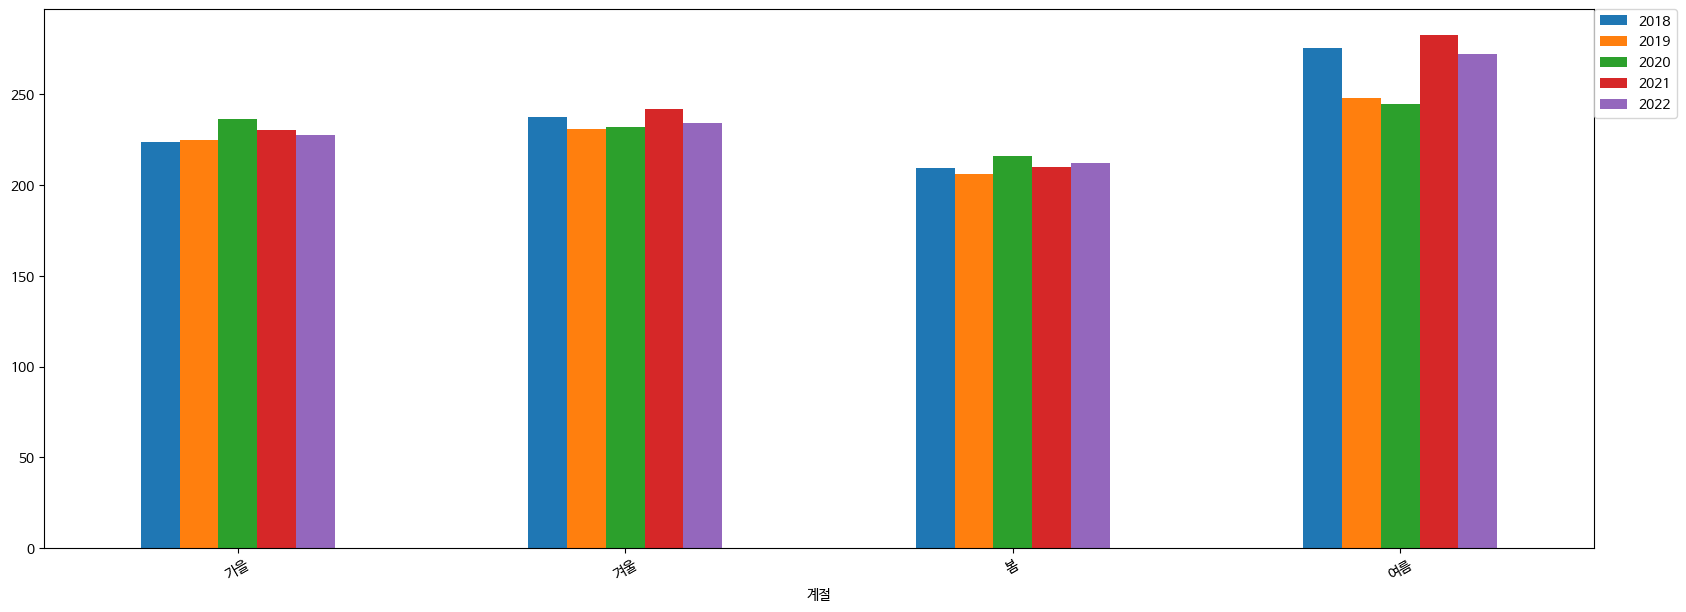

In [8]:
p = seoul_df[seoul_df.year != '2023'].pivot_table(index="계절", columns="year", values="powerUsage")
p.plot(kind='bar', figsize=(20, 7), rot=30)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0)
# plt.savefig(f"barplot.png")
plt.show()

### 파이차트 
* 2018.12 ~ 2022.11 데이터 사용, 연도별 원형그래프 
* 계절별 사용량 결과는 모두 "여름 > 겨울 > 가을 > 봄" 순서대로 결과가 나왔다

In [9]:
def pieCart(df, year):
    colors = ['lightcoral', 'lightskyblue','yellowgreen', 'gold']
    wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
    textprops = dict(weight=4,size=20)
    plt.title(f"{year} 전력평균")
    plt.pie( df[year], labels=df.index, colors=colors, textprops=textprops, wedgeprops=wedgeprops,
            labeldistance=1.2, autopct='%1.1f%%', shadow=True, startangle=0)
    plt.axis('equal')
    #plt.savefig(f"pieplot_{year}.png")
    plt.show()

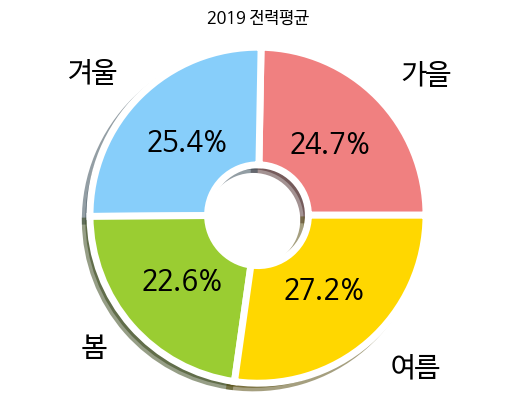

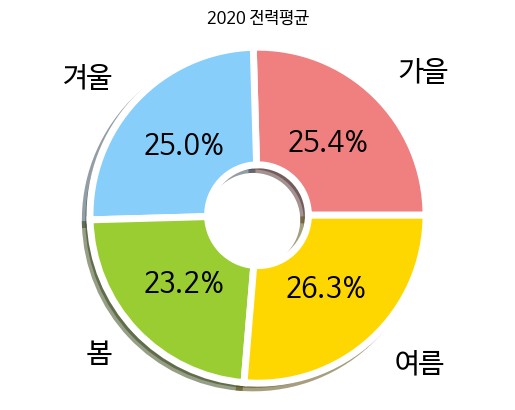

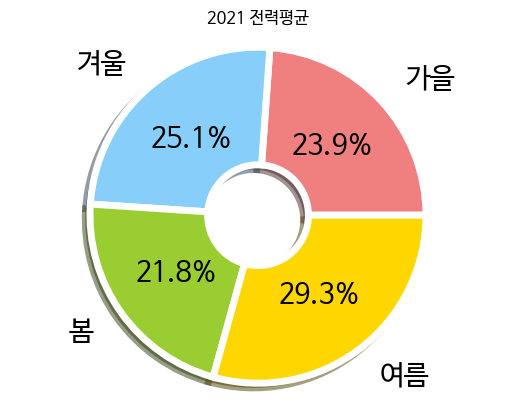

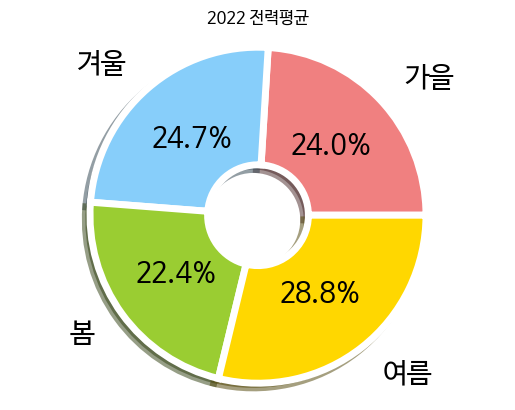

In [10]:
years = ['2019','2020','2021','2022']
Data_df = seoul_df[(seoul_total_df["year"]== '2018') & (seoul_df['month']=='12')] #초기화: 2018년 12월 데이터

for year in years:
    tmp_df = seoul_df[seoul_df["year"] == year]
    except_12 = tmp_df[tmp_df.month != '12'] # 이번해 12월 제거
    
    Data_df = pd.concat([Data_df,except_12]) # 이전해 12월과 이번해 11월까지 데이터
    #print(Data_df)
    
    Data_df = tmp_df.pivot_table(index="계절", columns="year", values="powerUsage")
    pieCart(Data_df, year)
    
    Data_df=tmp_df[tmp_df['month']=='12'] # 이번해 12월을 넣어서 초기화

In [11]:
#subplot
def pieCart2(df, year):
    colors = ['lightcoral', 'lightskyblue','yellowgreen', 'gold']
    wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
    textprops = dict(weight=4,size=20)
    
    plt.subplot(2,2,years.index(year)+1)
    plt.title(f"{year} 전력평균")
    plt.pie( df[year], labels=df.index, colors=colors, textprops=textprops, wedgeprops=wedgeprops,
            labeldistance=1.2, autopct='%1.1f%%', shadow=True, startangle=0)
    plt.axis('equal')

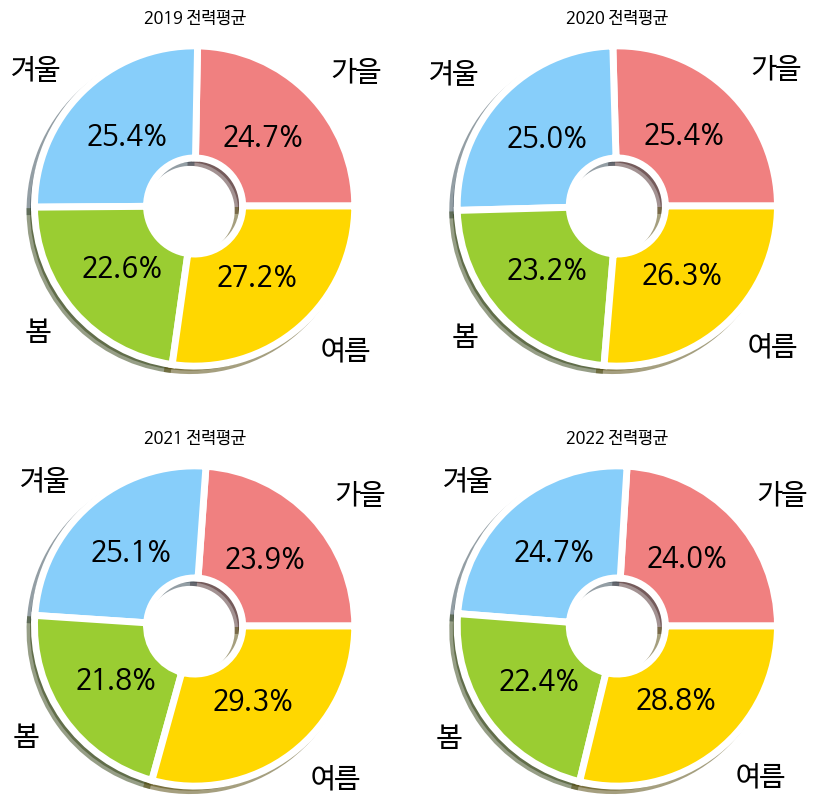

In [12]:
years = ['2019','2020','2021','2022']
Data_df = seoul_df[(seoul_df["year"]== '2018') & (seoul_df['month']=='12')] #초기화: 2018년 12월 데이터

plt.figure(figsize = (10, 10))
for year in years:
    tmp_df = seoul_df[seoul_df["year"] == year]
    except_12 = tmp_df[tmp_df.month != '12'] # 이번해 12월 제거
    
    Data_df = pd.concat([Data_df,except_12]) # 이전해 12월과 이번해 11월까지 데이터
    #print(Data_df)
    
    Data_df = tmp_df.pivot_table(index="계절", columns="year", values="powerUsage")
    pieCart2(Data_df, year)
    
    Data_df=tmp_df[tmp_df['month']=='12'] # 이번해 12월을 넣어서 초기화
plt.show()
# plt.savefig(f"pieplot.png")